In [ ]:
pip install -U bitsandbytes

In [1]:
from datasets import load_dataset

# Load Tiny Shakespeare
dataset = load_dataset("tiny_shakespeare")
text = dataset["train"]["text"][0]  # Full text

# Preview
print(text[:500] + "...")

README.md:   0%|          | 0.00/6.10k [00:00<?, ?B/s]

tiny_shakespeare.py:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

The repository for tiny_shakespeare contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/tiny_shakespeare.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


Generating train split:   0%|          | 0/1 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1 [00:00<?, ? examples/s]

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor...


In [2]:
import requests

url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text

print(f"Dataset length: {len(text):,} characters")
print(text[:500])  # Preview

Dataset length: 1,115,394 characters
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


# EDA

In [3]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Split text into words
words = text.split()
word_counts = Counter(words)

In [4]:

df_word_counts = pd.DataFrame(word_counts.items(), columns=["word", "count"]).sort_values("count", ascending=False)

print(f"Total words: {len(words):,}")
print(f"Unique words: {len(word_counts):,}")
print("\nTop 10 words:")
print(df_word_counts.head(10))

Total words: 202,651
Unique words: 25,670

Top 10 words:
     word  count
31    the   5437
118     I   4403
17     to   3923
40    and   3678
98     of   3275
231    my   2677
49      a   2610
24    you   2130
120    in   2073
94   that   1812


# 2. Word Frequency Distribution

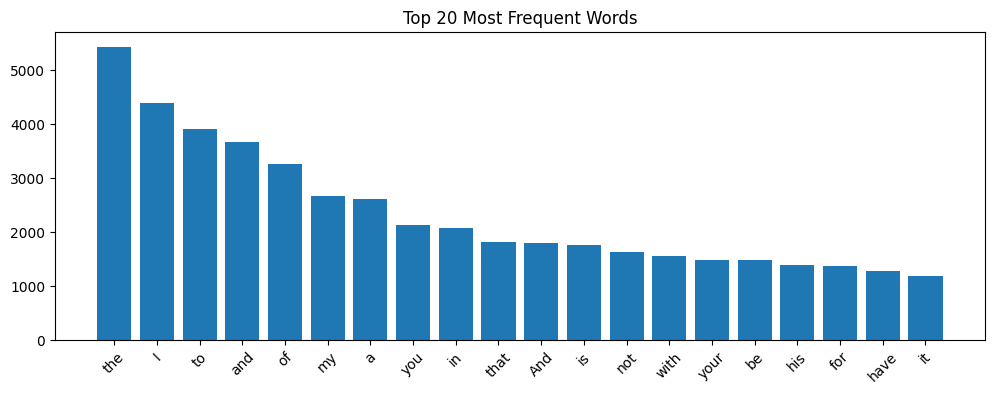

In [5]:
plt.figure(figsize=(12, 4))
plt.bar(df_word_counts["word"][:20], df_word_counts["count"][:20])
plt.title("Top 20 Most Frequent Words")
plt.xticks(rotation=45)
plt.show()

# 3. WordCloud

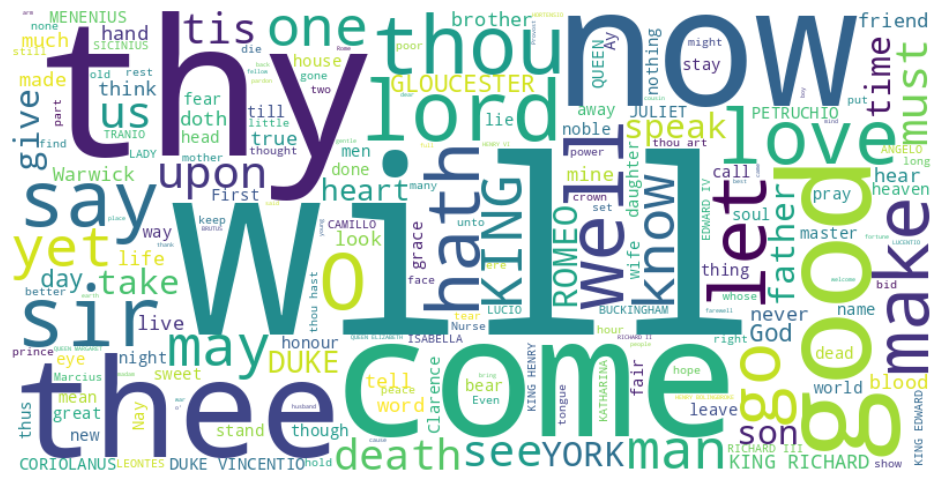

In [6]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# 4. N-gram Analysis (Bigrams)

In [7]:
from nltk import ngrams
from nltk.tokenize import word_tokenize

# Generate bigrams
bigrams = list(ngrams(words, 2))
bigram_counts = Counter(bigrams)

# Top 10 bigrams
pd.DataFrame(bigram_counts.most_common(10), columns=["bigram", "count"])

,bigram,count
0,"(to, the)",352
1,"(I, am)",349
2,"(I, have)",333
3,"(in, the)",319
4,"(of, the)",289
5,"(I, will)",264
6,"(KING, RICHARD)",236
7,"(to, be)",203
8,"(DUKE, VINCENTIO:)",193
9,"(is, the)",160


In [8]:

# Generate bigrams
bigrams = list(ngrams(words, 3))
bigram_counts = Counter(bigrams)

# Top 10 bigrams
pd.DataFrame(bigram_counts.most_common(10), columns=["bigram", "count"])

,bigram,count
0,"(KING, RICHARD, III:)",138
1,"(KING, EDWARD, IV:)",110
2,"(KING, RICHARD, II:)",98
3,"(DUCHESS, OF, YORK:)",71
4,"(KING, HENRY, VI:)",71
5,"(DUKE, OF, YORK:)",54
6,"(I, will, not)",40
7,"(DUKE, OF, AUMERLE:)",38
8,"(the, Duke, of)",36
9,"(JOHN, OF, GAUNT:)",28


# 5. Sentence Length Analysis

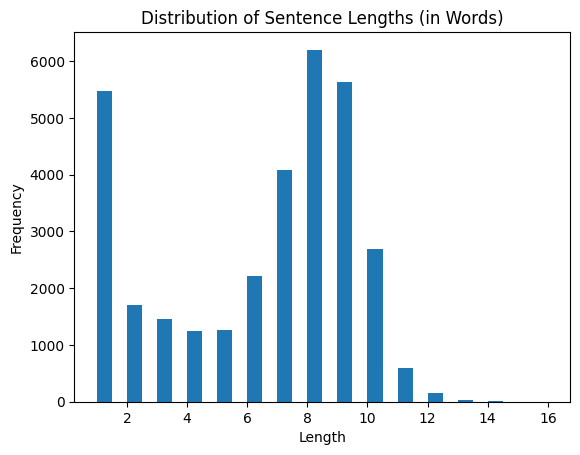

In [9]:
sentences = text.split('\n')  # Simple split by newline
sentence_lengths = [len(s.split()) for s in sentences if len(s) > 0]

plt.hist(sentence_lengths, bins=30)
plt.title("Distribution of Sentence Lengths (in Words)")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

## Subword Tokenization (Byte-Pair Encoding - BPE)
Why BPE?
Balances between character-level (too granular) and word-level (large vocab).

Handles rare/unknown words by breaking them into subwords (e.g., "unhappiness" → "un", "happiness").

## Step 1: Train a BPE Tokenizer

In [10]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, processors

# Initialize a BPE tokenizer
tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

# Trainer setup
trainer = trainers.BpeTrainer(
    vocab_size=1000,  # Small for demo (typical: 10K-50K)
    special_tokens=["[UNK]", "[PAD]", "[BOS]", "[EOS]"]
)

# Train on the dataset
tokenizer.train_from_iterator([text], trainer=trainer)

# Save/Load
tokenizer.save("shakespeare_bpe.json")
tokenizer = Tokenizer.from_file("shakespeare_bpe.json")

In [11]:
# Encode
encoded = tokenizer.encode("ROMEO: Where art thou?")
print("Tokens:", encoded.tokens)
print("IDs:", encoded.ids)

Tokens: ['ROMEO', ':', 'Where', 'art', 'thou', '?']
IDs: [594, 12, 492, 195, 130, 14]


In [12]:
# Decode
decoded = tokenizer.decode(encoded.ids)
print("Decoded:", decoded)

Decoded: ROMEO : Where art thou ?


In [13]:
from transformers import PreTrainedTokenizerFast

# Convert your custom tokenizer to HuggingFace format
hf_tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer,  # Your existing Tokenizer object
    unk_token="[UNK]",
    pad_token="[PAD]",
    bos_token="[BOS]",
    eos_token="[EOS]",
)

# Save/load like a standard HF tokenizer
hf_tokenizer.save_pretrained("custom_bpe_tokenizer")
hf_tokenizer = PreTrainedTokenizerFast.from_pretrained("custom_bpe_tokenizer")

# Test
encoded = hf_tokenizer("ROMEO: Where art thou?")
print(encoded.tokens())  # Should match your BPE output

['ROMEO', ':', 'Where', 'art', 'thou', '?']


If you are using custom tokenizer then you need to adjust the size of your model token embedding dimension..

In [ ]:
from transformers import GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(hf_tokenizer))  # Resize for custom vocab

# Training

# 4. Load GPT-2 Small with 4-bit Quantization

In [14]:
from transformers import GPT2LMHeadModel, BitsAndBytesConfig
import torch

# 4-bit config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

# Load quantized model
model = GPT2LMHeadModel.from_pretrained(
    "gpt2",
    quantization_config=bnb_config,
    device_map="auto"  # Automatically offloads to CPU
)

print(f"Model size: {model.get_memory_footprint() / 1e6:.2f} MB (4-bit)")
# Resize embeddings for custom tokenizer
model.resize_token_embeddings(len(hf_tokenizer))
print(f"Model size: {model.get_memory_footprint() / 1e6:.2f} MB (4-bit)")

2025-04-20 09:21:23.406982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745140883.429361     131 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745140883.436200     131 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Model size: 134.06 MB (4-bit)
Model size: 58.40 MB (4-bit)


# 5. Apply LoRA (PEFT)

In [16]:
from peft import LoraConfig, get_peft_model

# LoRA config
lora_config = LoraConfig(
    r=16,  # Rank
    lora_alpha=32,
    target_modules=["c_attn"],  # Target attention layers in GPT-2
    lora_dropout=0.05,
    task_type="CAUSAL_LM"
)

# Wrap model with LoRA
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 589,824 || all params: 87,200,256 || trainable%: 0.6764


# 6. Fine-Tuning start

In [17]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling

# Tokenize dataset
def tokenize(examples):
    return hf_tokenizer(examples["text"], truncation=True, max_length=128, padding="max_length")  # Use hf_tokenizer instead

tokenized_dataset = dataset.map(tokenize, batched=True)

# Training args (CPU-friendly)
training_args = TrainingArguments(
    output_dir="./output",
    per_device_train_batch_size=2,  # Small batch for CPU
    num_train_epochs=1,              # Quick demo
    save_steps=100,
    logging_steps=10,
    fp16=False,  # Disable mixed precision (CPU-safe)
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)
)



Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [19]:
print("Starting training...")
#trainer.train() # would not work

Starting training...


Full CPU Inference Example

## Use existing tokenizer to train

In [22]:

# Optimized imports
from transformers import (
    GPT2LMHeadModel, GPT2TokenizerFast,
    TrainingArguments, Trainer, DataCollatorForLanguageModeling,
    BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model
import torch
from datasets import Dataset
import requests

# 1. Faster dataset loading - use raw text directly
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
text = requests.get(shakespeare_url).text[:30000]  # Use first 30k chars for speed

# 2. Proper tokenizer setup with padding
print("Loading tokenizer...")
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Set pad token to eos_token
tokenizer.padding_side = "left"  # Important for text generation

# 3. Optimized model loading with 4-bit quantization
print("Loading 4-bit model...")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True  # Additional memory savings
)

model = GPT2LMHeadModel.from_pretrained(
    "gpt2",
    quantization_config=bnb_config,
    device_map="auto"
)

# 4. Efficient LoRA setup
peft_config = LoraConfig(
    r=8, 
    lora_alpha=32,
    target_modules=["c_attn"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# 5. Faster data preparation with proper padding
print("Preparing dataset...")
block_size = 128  # Increased from 64 but still manageable
text_chunks = [text[i:i+block_size] for i in range(0, len(text), block_size)]
print("Preparing dataset completed")
# Tokenize in one batch with proper padding setup
tokenized = tokenizer(
    text_chunks,
    truncation=True,
    max_length=block_size,
    padding="max_length",
    return_tensors="pt"
)

dataset = Dataset.from_dict({
    "input_ids": tokenized["input_ids"],
    "attention_mask": tokenized["attention_mask"]
})

# 6. Optimized training setup for Kaggle GPU
training_args = TrainingArguments(
    output_dir="./output",
    per_device_train_batch_size=16,  # Increased batch size for GPU
    num_train_epochs=10,
    logging_steps=2,
    save_steps=100,
    fp16=True,  # Enable mixed precision
    gradient_accumulation_steps=2,  # Better GPU utilization
    optim="adamw_torch",  # Better optimizer
    report_to="none",  # Disable wandb/etc
    disable_tqdm=False  # Show progress bar
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    data_collator=DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False  # Causal language modeling
    )
)





Loading tokenizer...
Loading 4-bit model...


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 294,912 || all params: 124,734,720 || trainable%: 0.2364
Preparing dataset...
Preparing dataset completed


In [23]:
# 7. Train with progress
print("Training...")
trainer.train()  # Built-in progress bar will show

Training...


Step,Training Loss
2,9.368900
4,9.438900
6,9.308000
8,9.666200
10,9.161300
12,9.347400
14,9.147800
16,8.933500
18,8.967600
20,8.895700


TrainOutput(global_step=70, training_loss=8.556044442313057, metrics={'train_runtime': 29.7709, 'train_samples_per_second': 78.936, 'train_steps_per_second': 2.351, 'total_flos': 135818564861952.0, 'train_loss': 8.556044442313057, 'epoch': 8.8})

In [25]:
# 8. Quick generation
print("\nSample generation:")
inputs = tokenizer("KING RICHARD:", return_tensors="pt").to(model.device)
outputs = model.generate(
    inputs.input_ids,
    max_length=50,
    temperature=0.7,
    do_sample=True,
    pad_token_id=tokenizer.eos_token_id
)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


Sample generation:
KING RICHARD: And I think there's a lot of people that are wondering why we have such a lack of understanding of the way things are made in the game of poker.

I think the game is so simple in these areas that


In [ ]:

# 1. First save your fine-tuned model properly (run this after training)
trainer.save_model("./output")  # This saves both adapter and model files
tokenizer.save_pretrained("./output")

In [ ]:
import os
# 6. Verify files exist after training
print("Files in output directory before saving:")
print(os.listdir("./output"))

# Improvement -> train model on entire text

In [27]:

# Optimized imports
from transformers import (
    GPT2LMHeadModel, GPT2TokenizerFast,
    TrainingArguments, Trainer, DataCollatorForLanguageModeling,
    BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model
import torch
from datasets import Dataset
import requests

# 1. Faster dataset loading - use raw text directly
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
text = requests.get(shakespeare_url).text  # Use first 30k chars for speed

# 2. Proper tokenizer setup with padding
print("Loading tokenizer...")
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Set pad token to eos_token
tokenizer.padding_side = "left"  # Important for text generation

# 3. Optimized model loading with 4-bit quantization
print("Loading 4-bit model...")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True  # Additional memory savings
)

model = GPT2LMHeadModel.from_pretrained(
    "gpt2",
    quantization_config=bnb_config,
    device_map="auto"
)

# 4. Efficient LoRA setup
peft_config = LoraConfig(
    r=8, 
    lora_alpha=32,
    target_modules=["c_attn"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# 5. Faster data preparation with proper padding
print("Preparing dataset...")
block_size = 128  # Increased from 64 but still manageable
text_chunks = [text[i:i+block_size] for i in range(0, len(text), block_size)]
print("Preparing dataset completed")
# Tokenize in one batch with proper padding setup
tokenized = tokenizer(
    text_chunks,
    truncation=True,
    max_length=block_size,
    padding="max_length",
    return_tensors="pt"
)

dataset = Dataset.from_dict({
    "input_ids": tokenized["input_ids"],
    "attention_mask": tokenized["attention_mask"]
})

# 6. Optimized training setup for Kaggle GPU
training_args = TrainingArguments(
    output_dir="./output",
    per_device_train_batch_size=16,  # Increased batch size for GPU
    num_train_epochs=10,
    logging_steps=2,
    save_steps=100,
    fp16=True,  # Enable mixed precision
    gradient_accumulation_steps=2,  # Better GPU utilization
    optim="adamw_torch",  # Better optimizer
    report_to="none",  # Disable wandb/etc
    disable_tqdm=False  # Show progress bar
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    data_collator=DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False  # Causal language modeling
    )
)





Loading tokenizer...
Loading 4-bit model...
trainable params: 294,912 || all params: 124,734,720 || trainable%: 0.2364
Preparing dataset...
Preparing dataset completed


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [28]:
# 7. Train with progress
print("Training...")
trainer.train() 

Training...


Step,Training Loss
2,9.656700
4,9.620200
6,9.316500
8,9.716600
10,9.509900
12,9.259000
14,9.330700
16,9.357300
18,8.870900
20,8.936600


TrainOutput(global_step=2720, training_loss=4.953116045629277, metrics={'train_runtime': 1249.0708, 'train_samples_per_second': 69.772, 'train_steps_per_second': 2.178, 'total_flos': 5693039660630016.0, 'train_loss': 4.953116045629277, 'epoch': 9.965137614678898})

In [29]:
# 8. Quick generation
print("\nSample generation:")
inputs = tokenizer("KING RICHARD:", return_tensors="pt").to(model.device)
outputs = model.generate(
    inputs.input_ids,
    max_length=50,
    temperature=0.7,
    do_sample=True,
    pad_token_id=tokenizer.eos_token_id
)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


Sample generation:
KING RICHARD:
I see that's not a secret.

THE HITCHEN:

And if it's a secret,
I can't put it to use.

CUTTIC:

And that


# GRADIO deployment